In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Deep Neural Network
## Session 4: One Hidden Layer, multi-class

- Moons Dataset
- Decision Boundary
- Loss curve

<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align = "left"/>

## Import Statements

In [2]:
###-----------------
### Import Libraries
###-----------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, 
                             confusion_matrix,
                             classification_report,
                             ConfusionMatrixDisplay)

## Setup Global Parameters

In [3]:
###----------------
### Some parameters
###----------------

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.2
EPOCHS = 10000  # number of epochs
ALPHA = 0.1  # learning rate
N_SAMPLES = 1000
TEST_SIZE  = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Generate Data Set
<div style="font-family: Arial; font-size:1.2em;">
Sklearn's dataset generator is good source of data for learning. To keep the example simple, I'll suggest  <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a> dataset generator.
</div>

In [4]:
X, y = datasets.make_moons(n_samples=N_SAMPLES, 
                           shuffle=True, 
                           noise= NOISE, 
                           random_state=RANDOM_STATE)
X[:5], y[:5]

(array([[ 0.90633951,  0.90267624],
        [-1.11536828,  0.75579289],
        [ 1.88769158,  0.4175967 ],
        [-0.93345034, -0.02299851],
        [-0.96872877,  0.06396285]]),
 array([0, 0, 1, 0, 0]))

## Visualization
<p style="font-family: Arial; font-size:1.2em">
DataFrames are easier to visualize
</p>

In [5]:
data_df = pd.DataFrame(X, columns = ['A', 'B'])

data_df['target'] = y

data_df.head()

,A,B,target
0,0.906340,0.902676,0
1,-1.115368,0.755793,0
2,1.887692,0.417597,1
3,-0.933450,-0.022999,0
4,-0.968729,0.063963,0


In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       1000 non-null   float64
 1   B       1000 non-null   float64
 2   target  1000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 23.6 KB


In [7]:
data_df.describe() # Generate descriptive statistic

,A,B,target
count,1000.000000,1000.000000,1000.00000
mean,0.490841,0.239025,0.50000
std,0.898951,0.540082,0.50025
min,-1.688795,-0.955280,0.00000
25%,-0.149565,-0.205090,0.00000
50%,0.500100,0.241163,0.50000
75%,1.095048,0.680394,1.00000
max,2.419113,1.612075,1.00000


In [8]:
# what labels are present?
data_df.target.unique()

array([0, 1])

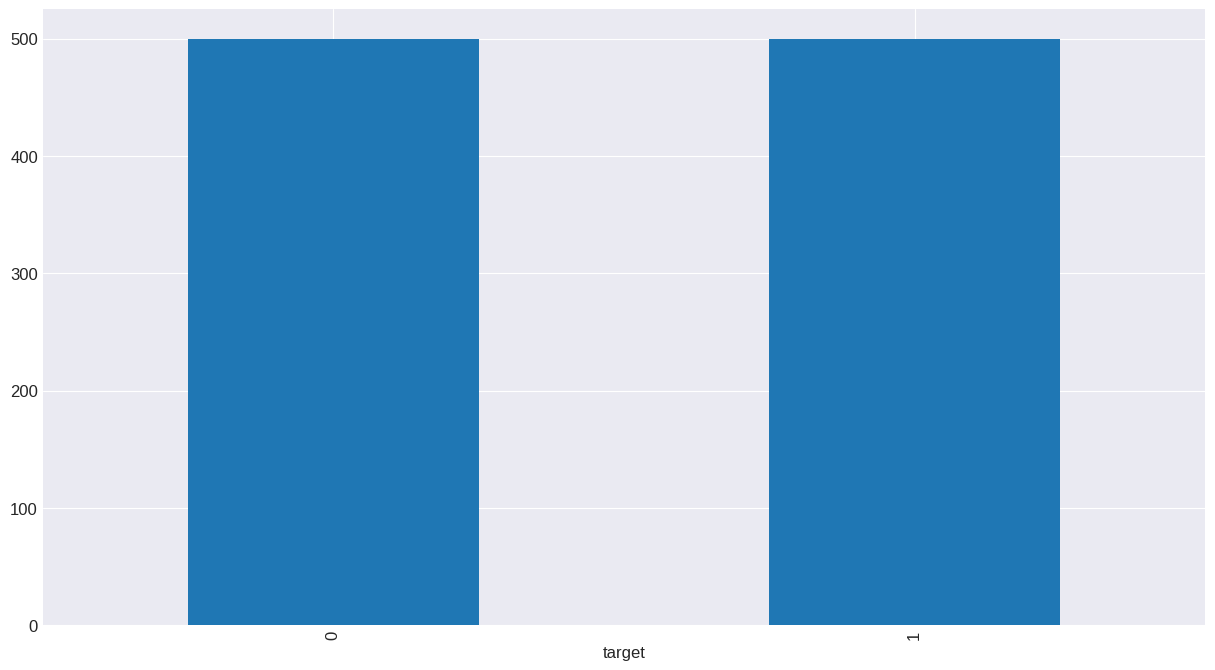

In [9]:
fig, ax = plt.subplots() # Instantiate
    
data_df['target'].value_counts().plot(ax=ax, kind='bar');

### Different ways of plotting data

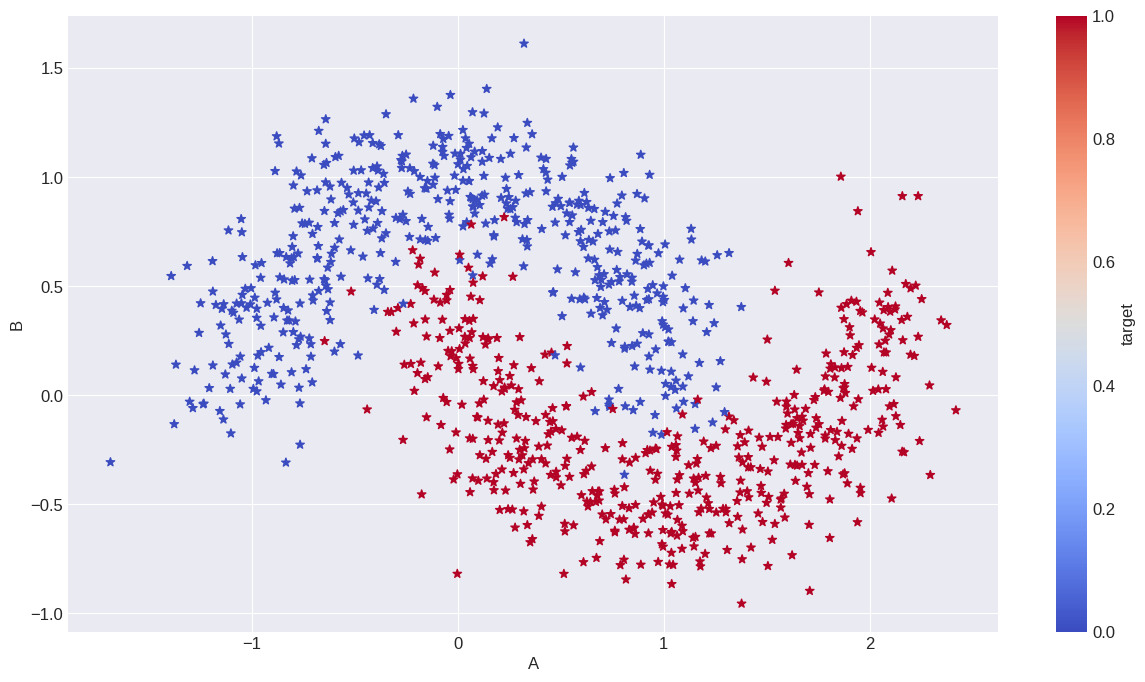

In [10]:
# Plot the data
data_df.plot.scatter('A', 'B',      # columns to plot
                     s = 40,        # size of the marker
                     marker = '*',  # type of marker
                     c = 'target',  # color as per target column
                     cmap=CMAP);    # using colormap

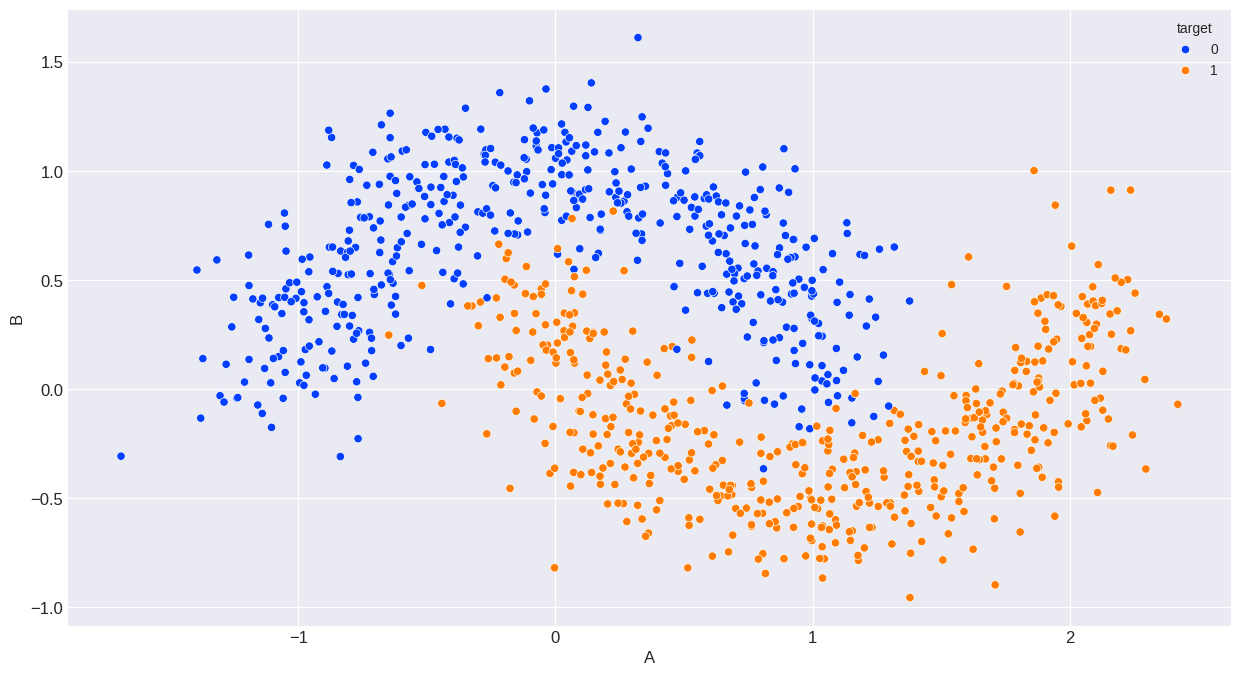

In [11]:
# Using Seaborn
ax = sns.scatterplot(data=data_df, # data from dataframe
                     x='A', y='B',  # X axis and y axis columns
                     palette=sns.color_palette("bright", 2), # color map
                     hue='target'); # Color as per target column

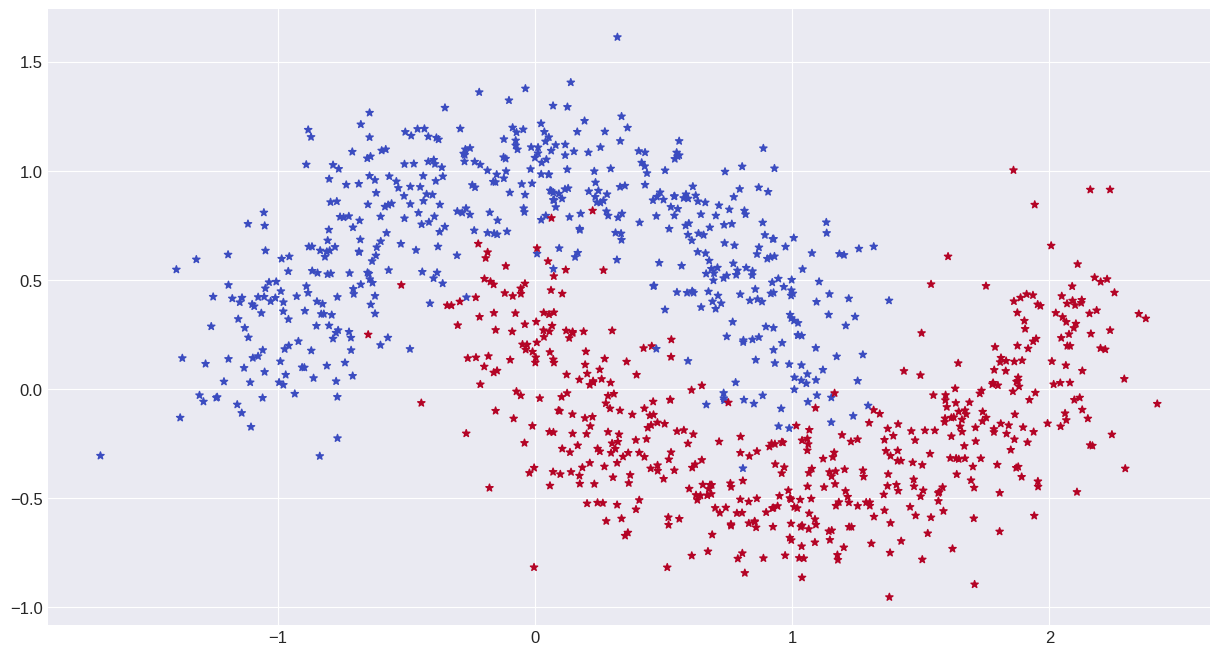

In [12]:
#### In case you want to plot X Array directly
plt.scatter(X[:,0], X[:,1], s=30, c=y, marker = '*', cmap=CMAP);

In [13]:
y = pd.get_dummies(y).to_numpy() # Converting to one-hot-encoding
y

array([[ True, False],
       [ True, False],
       [False,  True],
       ...,
       [ True, False],
       [False,  True],
       [ True, False]])

In [14]:
y.shape

(1000, 2)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800, 2), (200, 2))

In [17]:
# softmax function
def fn_softmax(z):
    '''
    Args:
        z : a matrix of z values of shape (m, n_output)
    returns:
        softmax values of z
    
    '''
    exp_z = np.exp(z)

    return exp_z / np.sum(exp_z, axis =1, keepdims=True ) 

In [18]:
sm = fn_softmax(np.asarray([[8, 5, 0], [-10, 0, 10]]))
#sm.sum(axis=1, keepdims=True).shape
sm.sum(axis=1).shape

(2,)

In [19]:
def fn_activ(z):
    return np.tanh(z)


def fn_activ_prime(a):
    return 1. - np.tanh(a)**2
    

In [20]:
def predict (model, X_p):

    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    # Layer1
    z1 = X_p.dot(W1) + b1 # Aggregation
    a1 = fn_activ(z1) # Activation

    # Layer 2
    z2 = a1.dot(W2) +b2 # Aggregation
    a2 = fn_softmax(z2) # Activation
    
    return np.argmax(a2, axis=1) # pick index of class with highest
                                 # probability

In [21]:
def calculate_loss (model, X_l, y_l):

    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    m = X_l.shape[0]
    
    # Layer1
    z1 = X_l.dot(W1) + b1 # Aggregation
    a1 = fn_activ(z1) # Activation

    # Layer 2
    z2 = a1.dot(W2) +b2 # Aggregation
    a2 = fn_softmax(z2) # Activation

    data_loss = -(y_l*np.log( a2 ) + 
                  ( 1 - y_l )* np.log( 1 - a2 ) ).sum() # Binary
    
    return data_loss / m

In [22]:
def build_model(X_tr, y_tr, 
                nn_hdim, nn_out, 
                alpha=ALPHA, epochs = EPOCHS):
    '''
    Args:
        X_tr : Training features
        y_tr : Training labels
        nn_hdim : number of nodes in the hidden layer
        nn_out : size of output
    '''
    m, nn_input_dim = X_tr.shape
    nn_output_dim = nn_out

    W1 = np.random.rand(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    
    W2 = np.random.rand(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    
    b1 = np.zeros((1, nn_hdim), dtype = np.float32)
    b2 = np.zeros((1, nn_output_dim), dtype = np.float32)

    curr_loss = 0

    loss, epoch = [], []

    for i in range (0, epochs):

        ### Forward Propagation

        # Layer1
        z1 = X_tr.dot(W1) + b1 # Aggregation z = X.W +b
        a1 = fn_activ(z1)      # Activation a = g(z)

        # Layer 2
        z2 = a1.dot(W2) +b2  # Aggregation z = X.W +b
        a2 = fn_softmax(z2)  # Activation a = g(z)

        ### Back propagation

        assert (a2.shape == y_tr.shape), f'check y {a2.shape}/{y_tr.shape}'
        dz2 = a2 - y_tr ## REMEMBER dim of a2 and y to be same dz = a-y

        dW2 = (a1.T).dot(dz2) # dw = a.dz
        assert (W2.shape == dW2.shape), f'check W2 {W2.shape}/{dW2.shape}'

        db2 = np.sum(dz2, axis = 0, keepdims=True) # db = dz ( sum along the column)
        assert (b2.shape == db2.shape), f'check b2 {b2.shape}/{db2.shape}'

        da1 = dz2.dot(W2.T) # da = W.dz
        assert (a1.shape == da1.shape), f'check b2 {a1.shape}/{da1.shape}'

        # Layer 1
        dz1 = da1 * fn_activ_prime(z1)
        assert (z1.shape == dz1.shape), f'check b2 {z1.shape}/{dz1.shape}'

        dW1 = (X_tr.T).dot(dz1) # dw = a.dz
        assert (W1.shape == dW1.shape), f'check W2 {W1.shape}/{dW1.shape}'

        db1 = np.sum(dz1, axis = 0, keepdims=True) # db = dz ( sum along the column)
        assert (b1.shape == db1.shape), f'check b2 {b1.shape}/{db1.shape}'

        ### Gradient Update
        W1 += -alpha * dW1 / m
        b1 += -alpha * db1 / m
        W2 += -alpha * dW2 / m
        b2 += -alpha * db2 / m

        model = {'W1' : W1, 'b1' : b1,
                 'W2' : W2, 'b2' : b2
                 }
        
        curr_loss = calculate_loss(model, X_tr, y_tr)
        loss.append(curr_loss)
        epoch.append(i)

        if i%1000 == 0:
            print (f'After epoch:{i:3d}; loss : {curr_loss: .5f}')

    loss_hist['epoch'] = epoch
    loss_hist['loss'] = loss
    
    return model

In [23]:
loss_hist = {}

In [24]:
nn_out_dim = 2

model = build_model(X_train, y_train, 4, nn_out_dim)

After epoch:  0; loss :  1.36221
After epoch:1000; loss :  0.53547
After epoch:2000; loss :  0.30131
After epoch:3000; loss :  0.18618
After epoch:4000; loss :  0.15943
After epoch:5000; loss :  0.15004
After epoch:6000; loss :  0.14540
After epoch:7000; loss :  0.14262
After epoch:8000; loss :  0.14074
After epoch:9000; loss :  0.13938


In [25]:
model['b2'].shape

(1, 2)

<Axes: xlabel='epoch'>

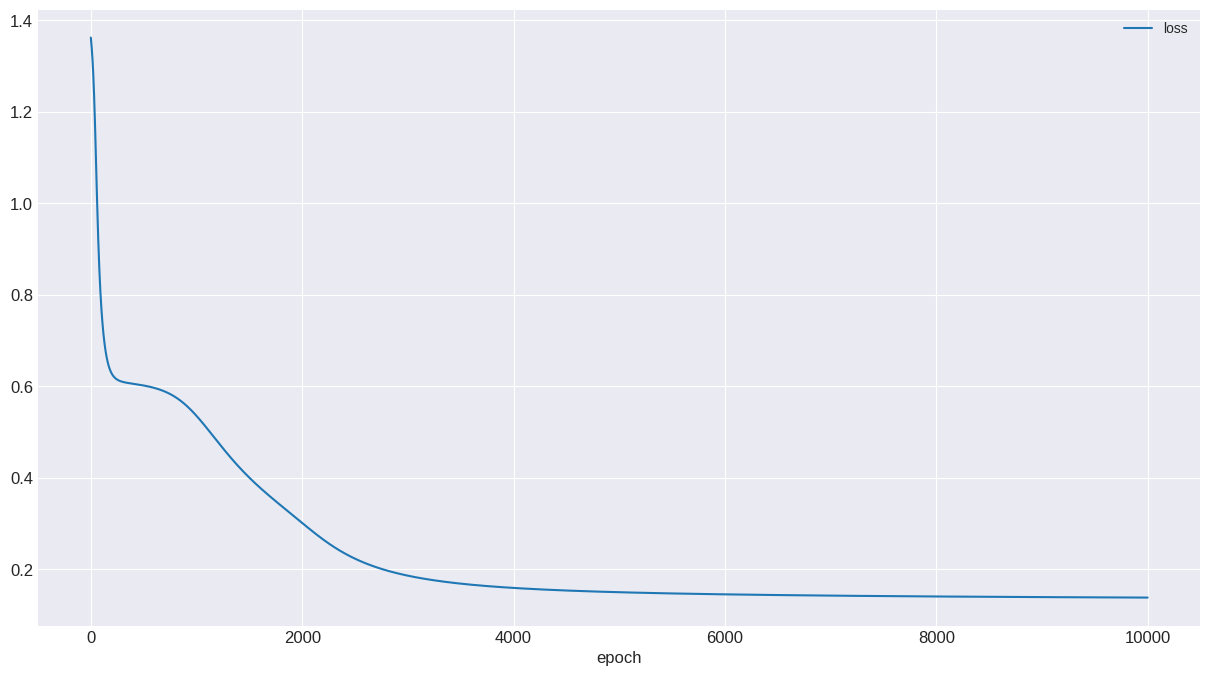

In [26]:
pd.DataFrame(loss_hist).plot(x = 'epoch')

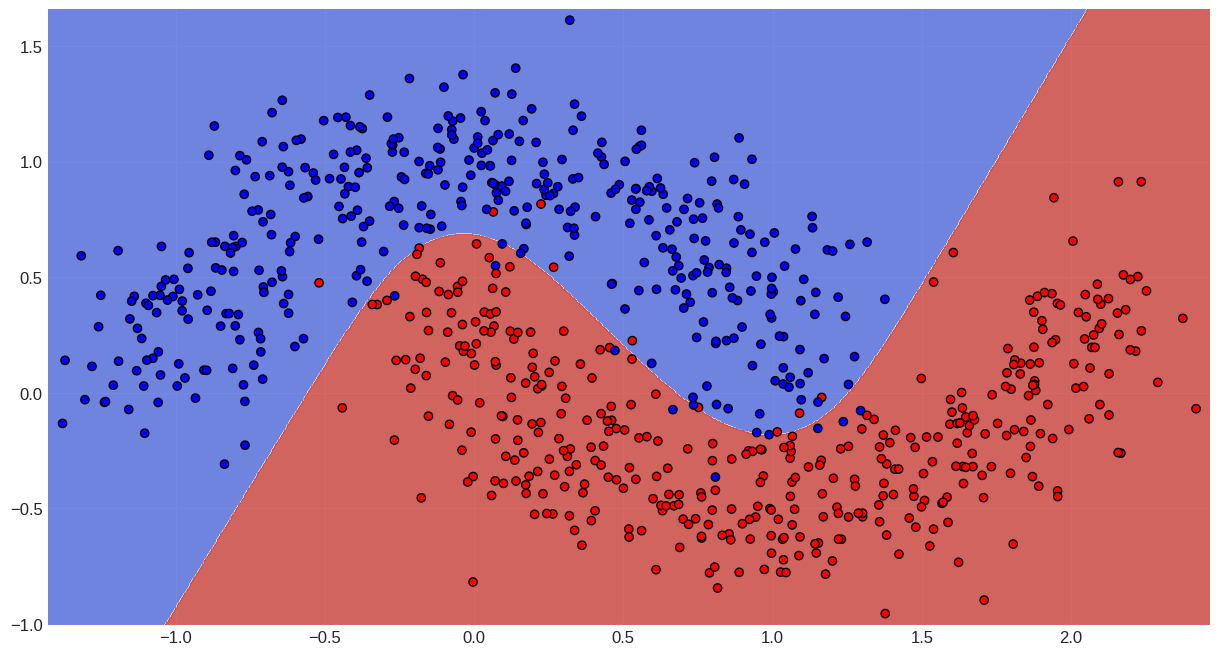

In [27]:
X = X_train
fig, ax = plt.subplots() # instantiation of plt objects
dm = 0.005 # spacing of the grid
x_min, x_max = X[:, 0].min() - 0.05 ,X[:, 0].max() + 0.05
y_min, y_max = X[:, 1].min() - 0.05 ,X[:, 1].max() + 0.05
xx,yy = np.meshgrid(np.arange(x_min, x_max, dm), 
                    np.arange(y_min, y_max, dm)) # generate a mesh
XX = np.c_[xx.ravel(), yy.ravel()] # prepare feature data

y_pred = predict(model, XX)

Z = np.array(y_pred).reshape(xx.shape)

ax.contourf(xx,yy, Z, cmap=CMAP, alpha = 0.8)

ax.scatter(X[:, 0], X[:, 1], c = y_train.argmax(axis = 1), 
           edgecolors='k', 
           cmap = plt.cm.bwr)

## Train data

In [29]:
y_pred = predict(model, X_train)
accuracy_score(y_train.argmax(axis = 1), y_pred)

0.9775

In [30]:
y_pred = predict(model, X_test)
accuracy_score(y_test.argmax(axis = 1), y_pred)

0.985

In [31]:
cm = confusion_matrix(y_test.argmax(axis = 1), y_pred)
cm

array([[99,  1],
       [ 2, 98]])

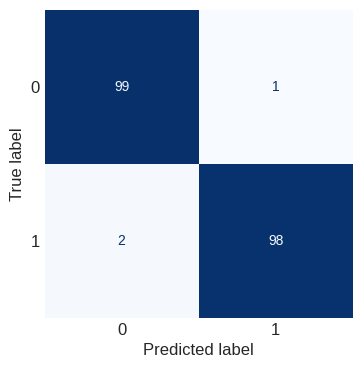

In [32]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])

fig, ax = plt.subplots(figsize=(4,4))

disp.plot(ax = ax, cmap='Blues', colorbar=False);
ax.grid(False);